In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import numpy as np

In [2]:
UK_SHP = "/Users/hester/Desktop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
PATH_AIRPORTS = "/Users/hester/Desktop/data/uk_airports_points.csv"

In [3]:
OUT_TIF = "/Users/hester/Desktop/data/air_binary.tif"

In [4]:
countries = gpd.read_file(UK_SHP)

uk = countries.loc[countries.get("ADMIN", "") == "United Kingdom"].copy()
if uk.empty and "ISO_A3" in countries.columns:
    uk = countries.loc[countries["ISO_A3"] == "GBR"].copy()
if uk.empty:
    raise ValueError("没在 ne_10m_admin_0_countries 里筛到 UK（United Kingdom/GBR），请检查字段名。")

uk = uk.dissolve()  
uk = uk.set_geometry("geometry")

In [5]:
#读取机场点 CSV -> GeoDataFrame

df = pd.read_csv(PATH_AIRPORTS)

g_air = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude_deg"], df["latitude_deg"]),
    crs="EPSG:4326")

In [6]:
uk_27700 = uk.to_crs("EPSG:27700")
air_27700 = g_air.to_crs("EPSG:27700")

buffer_15km = air_27700.copy()
buffer_15km["geometry"] = air_27700.buffer(15000)  

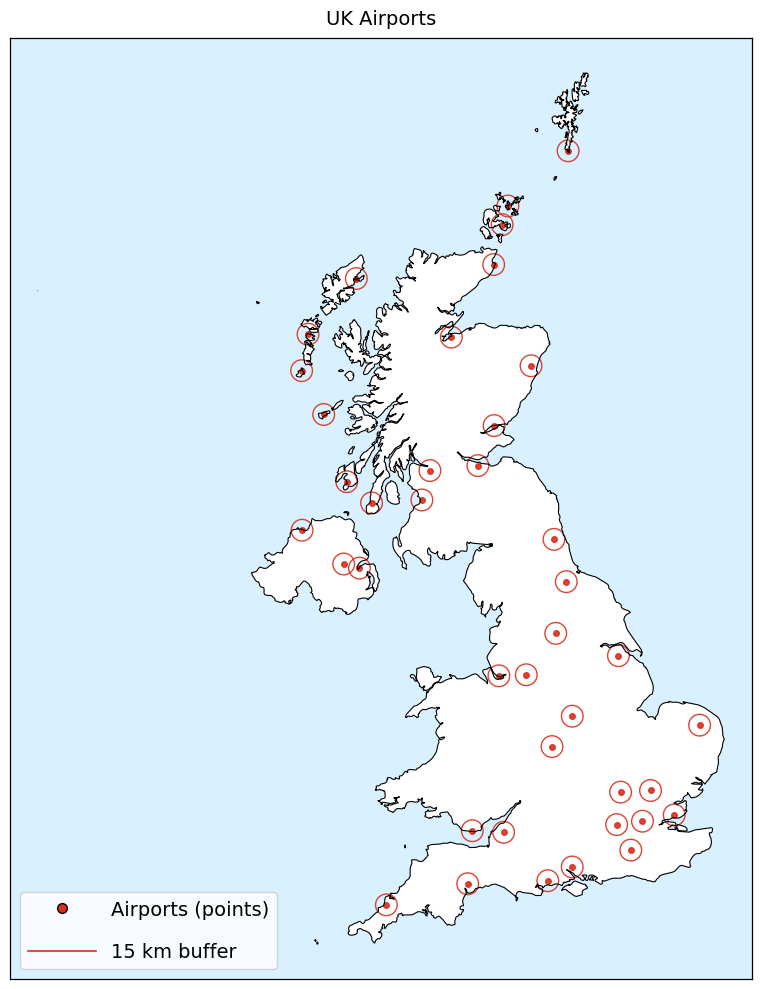

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

# 海洋
ax.set_facecolor("#d9f0ff") 

# 陆地
uk_27700.plot(ax=ax, facecolor="white", edgecolor="none", zorder=1)

buffer_15km.plot(
    ax=ax,
    facecolor="none",
    edgecolor="#d7301f",
    linewidth=1.0,
    alpha=0.9,
    zorder=2
)

# 机场点
air_27700.plot(
    ax=ax,
    color="#d7301f",
    markersize=16,
    alpha=0.9,
    zorder=3)

uk_27700.boundary.plot(ax=ax, edgecolor="black", linewidth=0.8, zorder=4)

ax.set_title("UK Airports", fontsize=14, pad=10)

minx, miny, maxx, maxy = uk_27700.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

legend_handles = [
    Line2D([0], [0], marker="o", color="none", markerfacecolor="#d7301f",
           markersize=7, label="Airports (points)"),
    Line2D([0], [0], color="#d7301f", linewidth=1.2, label="15 km buffer")
]
ax.legend(handles=legend_handles, loc="lower left", fontsize=14, labelspacing=1.2,handlelength=3.5)
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")
    
plt.tight_layout()
plt.show()
fig.savefig("UK Airports.png", dpi=300, bbox_inches="tight")

In [46]:
PATH_TIF= "/Users/hester/Desktop/data/terrain.tif"

In [28]:
with rasterio.open(PATH_TIF) as src:
    arr = src.read(1)
    nodata = src.nodata
    bounds = src.bounds
    crs = src.crs

# UK 投影到栅格 CRS（对齐）
uk = uk.to_crs(crs)

a = arr.astype("float32")
if nodata is not None:
    a[a == nodata] = np.nan

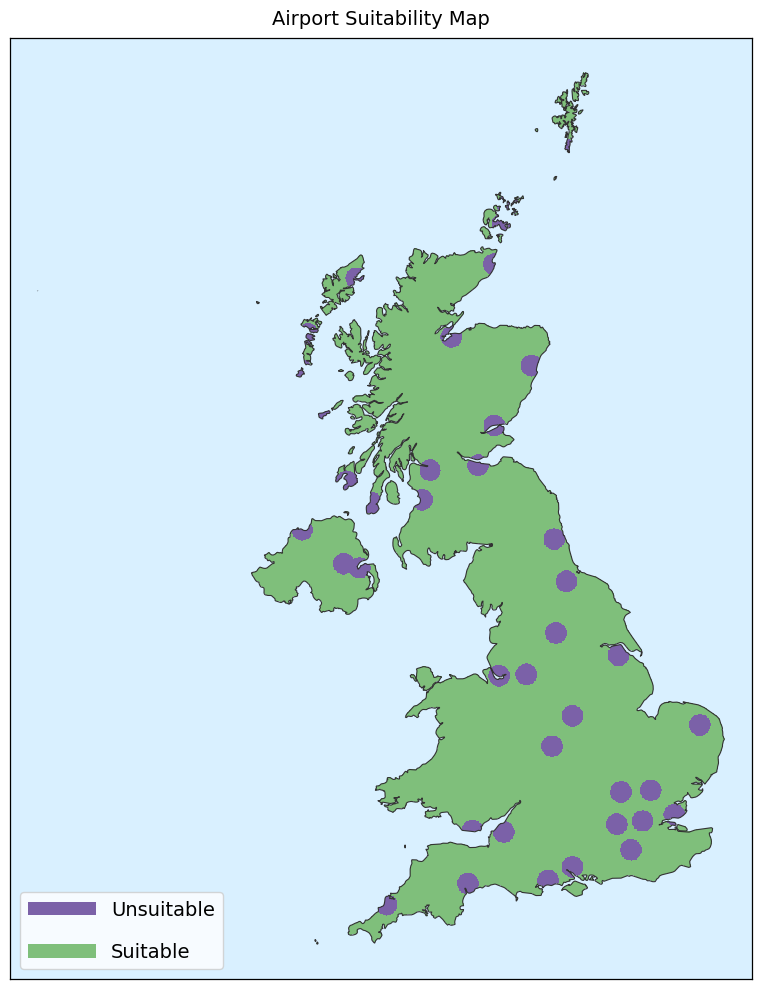

In [9]:
OUT_TIF = "/Users/hester/Desktop/data/air_binary.tif"


# 读 UK 边界 EPSG:27700
world = gpd.read_file(UK_SHP)
if "ISO_A3" in world.columns:
    uk = world[world["ISO_A3"] == "GBR"].dissolve()
else:
    key_cols = [c for c in ["ADMIN","NAME","SOVEREIGNT"] if c in world.columns]
    mask = False
    for c in key_cols:
        mask = mask | world[c].astype(str).str.contains("United Kingdom", case=False, na=False)
    uk = world[mask].dissolve()

uk = uk.to_crs("EPSG:27700")


res = 1000  # meters
minx, miny, maxx, maxy = uk.total_bounds

pad = 20000  
minx -= pad; miny -= pad; maxx += pad; maxy += pad

width  = int(np.ceil((maxx - minx) / res))
height = int(np.ceil((maxy - miny) / res))

transform = from_origin(minx, maxy, res, res) 

# 读机场点EPSG:27700 

df = pd.read_csv(PATH_AIRPORTS)

air = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude_deg"], df["latitude_deg"]),
    crs="EPSG:4326"
).to_crs("EPSG:27700")

buffers = air.buffer(15000)  

land = rasterize(
    [(uk.geometry.iloc[0], 1)],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8"
)


suit = rasterize(
    [(geom, 0) for geom in buffers if geom is not None and not geom.is_empty],
    out_shape=(height, width),
    transform=transform,
    fill=1,
    dtype="uint8"
)

nodata = 255
suit = np.where(land == 1, suit, nodata).astype("uint8")

profile = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": "uint8",
    "crs": "EPSG:27700",
    "transform": transform,
    "nodata": nodata,
    "compress": "lzw"
}

with rasterio.open(OUT_TIF, "w", **profile) as dst:
    dst.write(suit, 1)


a = suit.astype("float32")
a[a == nodata] = np.nan 


cmap = ListedColormap(["#7b61a8", "#7fbf7b"]) 
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)


left = minx
right = minx + width * res
top = maxy
bottom = maxy - height * res

fig, ax = plt.subplots(1, 1, figsize=(8,10))
ax.set_facecolor("#d9f0ff")

ax.imshow(
    a, cmap=cmap, norm=norm, interpolation="nearest",
    extent=[left, right, bottom, top], origin="upper"
)

uk.boundary.plot(ax=ax, edgecolor="#333333", linewidth=0.8)

ax.set_title("Airport Suitability Map", fontsize=14, pad=10)

minx, miny, maxx, maxy = uk.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)
ax.set_aspect("equal", adjustable="box")

legend_elements = [
    Patch(facecolor="#7b61a8", edgecolor="none", label="Unsuitable"),
    Patch(facecolor="#7fbf7b", edgecolor="none", label="Suitable")
]
ax.legend(handles=legend_elements, loc="lower left", fontsize=14, labelspacing=1.2,handlelength=3.5)
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()
fig.savefig("Airport Suitability Map.png", dpi=300, bbox_inches="tight")